In [63]:
%pip install umap-learn
%pip install hdbscan

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [64]:
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from umap import UMAP
import os
import json
from joblib import Parallel, delayed

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

file_path = r"C:\Users\yoshi\OneDrive\Desktop\CSMaster\CS439\FInalProj\legalData\legal_text_classification.csv"
df = pd.read_csv(file_path)

print("Dataset loaded:")
print(df.head())
print("Columns:", df.columns)

Dataset loaded:
  case_id case_outcome                                         case_title  \
0   Case1        cited  Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...   
1   Case2        cited  Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...   
2   Case3        cited  Colgate Palmolive Co v Cussons Pty Ltd (1993) ...   
3   Case4        cited  Dais Studio Pty Ltd v Bullett Creative Pty Ltd...   
4   Case5        cited  Dr Martens Australia Pty Ltd v Figgins Holding...   

                                           case_text  
0  Ordinarily that discretion will be exercised s...  
1  The general principles governing the exercise ...  
2  Ordinarily that discretion will be exercised s...  
3  The general principles governing the exercise ...  
4  The preceding general principles inform the ex...  
Columns: Index(['case_id', 'case_outcome', 'case_title', 'case_text'], dtype='object')


In [65]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    return ''

df['cleaned_text'] = df['case_text'].apply(preprocess_text)
print("Preprocessed text:")
print(df[['case_text', 'cleaned_text']].head())
def parallel_preprocess(texts):
    return Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in texts)

Preprocessed text:
                                           case_text  \
0  Ordinarily that discretion will be exercised s...   
1  The general principles governing the exercise ...   
2  Ordinarily that discretion will be exercised s...   
3  The general principles governing the exercise ...   
4  The preceding general principles inform the ex...   

                                        cleaned_text  
0  ordinarily discretion exercised cost follow ev...  
1  general principle governing exercise discretio...  
2  ordinarily discretion exercised cost follow ev...  
3  general principle governing exercise discretio...  
4  preceding general principle inform exercise di...  


In [66]:
keywords = {
        'family': ['children', 'custody', 'divorce', 'marriage', 'adoption', 'parenting orders', 'child support', 'spousal maintenance', 'family violence', 'guardianship', 'prenuptial agreements', 'alimony', 'domestic violence'],
        'property': ['property', 'ownership', 'land', 'real estate', 'lease', 'easements', 'mortgages', 'foreclosure', 'zoning', 'landlord', 'tenant', 'eviction', 'title deed', 'encumbrance'],
        'criminal': ['theft', 'murder', 'assault', 'fraud', 'crime', 'sentencing', 'bail', 'parole', 'prosecution', 'homicide', 'robbery', 'drug offenses', 'cybercrime', 'indictment'],
        'business': ['contract', 'agreement', 'corporation', 'partnership', 'mergers', 'franchises', 'intellectual property', 'trade practices', 'fiduciary duty', 'arbitration', 'joint venture'],
        'financial_and_securities': ['securities', 'investments', 'insider trading', 'market manipulation', 'financial services', 'hedge fund', 'derivatives', 'prospectus', 'IPO', 'compliance'],
        'administrative': ['judicial review', 'government decisions', 'statutory interpretation', 'licensing', 'zoning laws', 'public policy', 'rulemaking'],
        'employment': ['workers comp', 'workplace harassment', 'discrimination', 'severance pay', 'collective bargaining', 'wrongful termination', 'employee benefits', 'wage theft'],
        'environmental': ['pollution', 'climate change', 'conservation', 'renewable energy', 'wildlife protection', 'hazardous waste', 'emissions trading'],
        'immigration': ['visa', 'asylum', 'deportation', 'naturalization', 'green card', 'refugee status', 'work permit'],
        'tax': ['tax evasion', 'tax deduction', 'capital gains', 'estate tax', 'tax compliance', 'double taxation', 'tax treaty', 'tax audit']
    }

def assign_category(text):
    if not isinstance(text, str):
        return 'other'

    text = text.lower()
    category_scores = {category: 0 for category in keywords.keys()}

    for category, words in keywords.items():
        for word in words:
            category_scores[category] += text.count(word)

    max_score = max(category_scores.values())
    if max_score == 0:
        return 'other'
    return max(category_scores, key=category_scores.get)

df['case_category'] = df['cleaned_text'].apply(assign_category)
print("Initial categories assigned:")
print(df['case_category'].value_counts())

Initial categories assigned:
case_category
other                       11865
business                     5081
property                     4402
criminal                     1124
immigration                   961
administrative                595
financial_and_securities      423
family                        297
employment                    178
environmental                  55
tax                             4
Name: count, dtype: int64


Category Distribution (case_category):
case_category
other                       11865
business                     5081
property                     4402
criminal                     1124
immigration                   961
administrative                595
financial_and_securities      423
family                        297
employment                    178
environmental                  55
tax                             4
Name: count, dtype: int64


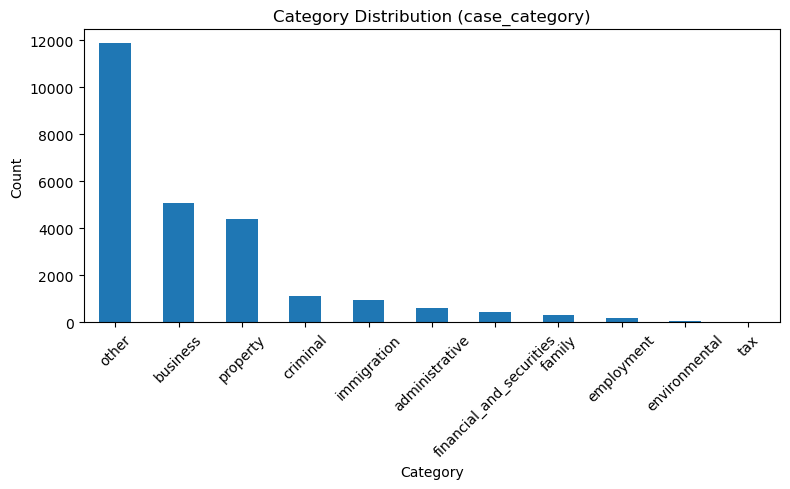

In [67]:
def evaluate_category_distribution(df, column='case_category'):
    category_counts = df[column].value_counts()
    print(f"Category Distribution ({column}):")
    print(category_counts)
    plt.figure(figsize=(8, 5))
    category_counts.plot(kind='bar', title=f'Category Distribution ({column})', 
                        xlabel='Category', ylabel='Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

evaluate_category_distribution(df)

Top terms for administrative:
['court', 'decision', 'tribunal', 'act', 'minister', 'case', 'applicant', 'law', 'application', 'fact']
Top terms for business:
['court', 'document', 'privilege', 'legal', 'advice', 'act', 'case', 'party', 'pty', 'claim']
Top terms for criminal:
['court', 'act', 'case', 'mr', 'applicant', 'evidence', 'appellant', 'person', 'pty', 'tribunal']
Top terms for employment:
['act', 'applicant', 'court', 'respondent', 'case', 'tribunal', 'person', 'application', 'claim', 'conduct']
Top terms for environmental:
['clr', 'case', 'hca', 'australian', 'court', 'act', 'fcr', 'applicant', 'australia', 'proceeding']
Top terms for family:
['court', 'case', 'tribunal', 'applicant', 'act', 'document', 'order', 'mr', 'reason', 'evidence']
Top terms for financial_and_securities:
['court', 'act', 'order', 'tribunal', 'decision', 'case', 'applicant', 'application', 'time', 'pty']
Top terms for immigration:
['tribunal', 'appellant', 'applicant', 'minister', 'decision', 'court', '

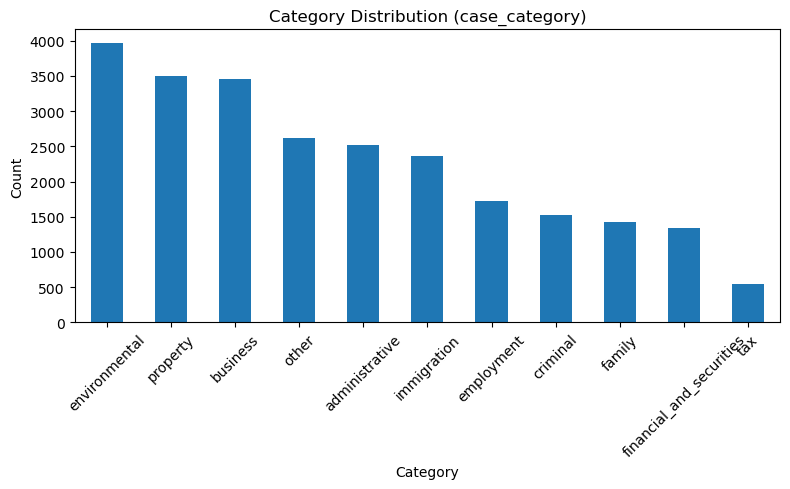

Cleaned text saved to legalData\cleaned_legal_text.csv


In [68]:
output_dir = 'legalData'
category_texts = df.groupby('case_category')['cleaned_text'].apply(' '.join)
tfidf_keywords = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix_keywords = tfidf_keywords.fit_transform(category_texts)

feature_names = tfidf_keywords.get_feature_names_out()
updated_keywords = {}
for i, category in enumerate(category_texts.index):
    print(f"Top terms for {category}:")
    sorted_indices = tfidf_matrix_keywords[i].toarray().argsort()[0][::-1]
    top_terms = [feature_names[idx] for idx in sorted_indices[:10]]  
    print(top_terms)
    if category in keywords:
        updated_keywords[category] = list(set(keywords[category] + top_terms))
    else:
        updated_keywords[category] = top_terms

keywords = updated_keywords
keywords_file = os.path.join(output_dir, 'updated_keywords.json')
with open(keywords_file, 'w') as f:
    json.dump(keywords, f, indent=4)
print(f"Updated keywords saved to {keywords_file}")

df['case_category'] = df['cleaned_text'].apply(assign_category)
print("Categories reassigned after updating keywords:")
print(df['case_category'].value_counts())
evaluate_category_distribution(df)

output_file = os.path.join(output_dir, 'cleaned_legal_text.csv')
df[['case_text', 'cleaned_text', 'case_category']].to_csv(output_file, index=False)
print(f"Cleaned text saved to {output_file}")

In [69]:
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 3), min_df=5, max_df=0.8)
tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])

feature_names = tfidf.get_feature_names_out()
top_indices = tfidf_matrix.mean(axis=0).A1.argsort()[-10:]
print("Top TF-IDF terms:", [feature_names[i] for i in top_indices])

Top TF-IDF terms: ['fca', 'per', 'case', 'act', 'applicant', 'pty ltd', 'pty', 'tribunal', 'court', 'ltd']


Silhouette Score for k=2: 0.020
Silhouette Score for k=3: 0.020
Silhouette Score for k=4: 0.017
Silhouette Score for k=5: 0.018
Silhouette Score for k=6: 0.021
Silhouette Score for k=7: 0.020
Silhouette Score for k=8: 0.025
Silhouette Score for k=9: 0.024
Silhouette Score for k=10: 0.028
Silhouette Score for k=11: 0.024
Silhouette Score for k=12: 0.030
Silhouette Score for k=13: 0.028
Silhouette Score for k=14: 0.030
Silhouette Score for k=15: 0.029
Silhouette Score for k=16: 0.034
Silhouette Score for k=17: 0.032
Silhouette Score for k=18: 0.027
Silhouette Score for k=19: 0.032


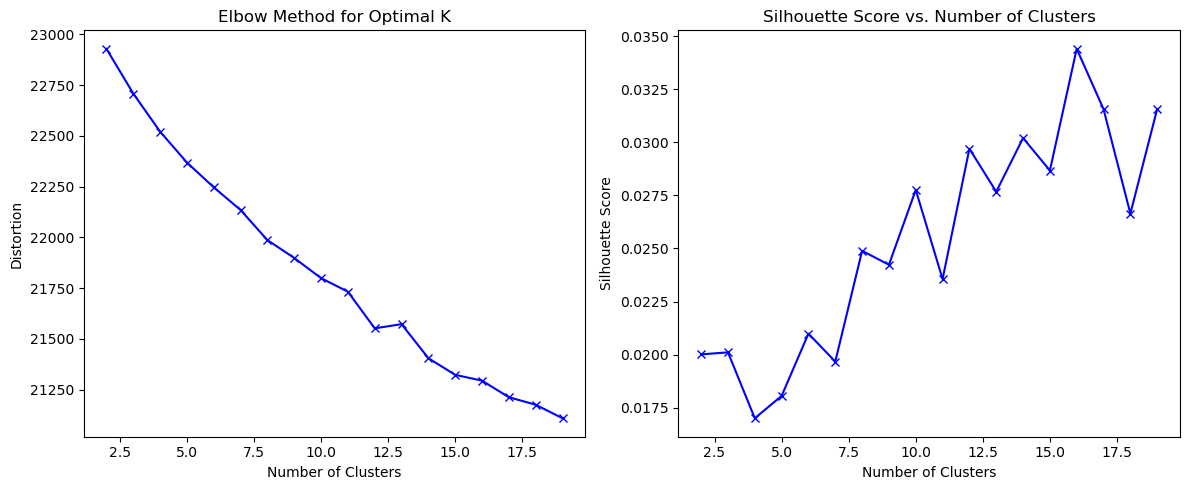

Optimal number of clusters: 16


In [70]:
silhouette_scores = []
K = range(2, 20)  
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=777, n_init=5)  
    labels = kmeans.fit_predict(tfidf_matrix)
    distortions.append(kmeans.inertia_)
    score = silhouette_score(tfidf_matrix, labels, sample_size=min(500, tfidf_matrix.shape[0]), random_state=777)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.3f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.tight_layout()
plt.show()


optimal_clusters = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

In [71]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=777, n_init=5)
df['cluster_kmeans'] = kmeans.fit_predict(tfidf_matrix)

silhouette_kmeans = silhouette_score(tfidf_matrix, df['cluster_kmeans'], 
                                    sample_size=min(500, tfidf_matrix.shape[0]), random_state=777)
calinski_harabasz_kmeans = calinski_harabasz_score(tfidf_matrix.toarray(), df['cluster_kmeans'])
print(f"KMeans Silhouette Score: {silhouette_kmeans:.3f}")
print(f"KMeans Calinski-Harabasz Index: {calinski_harabasz_kmeans:.2f}")

KMeans Silhouette Score: 0.034
KMeans Calinski-Harabasz Index: 168.77


In [72]:
# UMAP reduction
umap = UMAP(n_components=20, random_state=777, metric='cosine', n_jobs=-1)
reduced_matrix = umap.fit_transform(tfidf_matrix)

# KMeans on reduced data
kmeans_umap = KMeans(n_clusters=optimal_clusters, random_state=777, n_init=5)
df['cluster_umap_kmeans'] = kmeans_umap.fit_predict(reduced_matrix)

# Evaluate
silhouette_umap = silhouette_score(reduced_matrix, df['cluster_umap_kmeans'], 
                                  sample_size=min(500, tfidf_matrix.shape[0]), random_state=777)
calinski_harabasz_umap = calinski_harabasz_score(reduced_matrix, df['cluster_umap_kmeans'])
print(f"UMAP + KMeans Silhouette Score: {silhouette_umap:.3f}")
print(f"UMAP + KMeans Calinski-Harabasz Index: {calinski_harabasz_umap:.2f}")

UMAP + KMeans Silhouette Score: 0.326
UMAP + KMeans Calinski-Harabasz Index: 7735.54


Top terms for cluster 0: ['see', 'creditor', 'order', 'acsr', 'case', 'act', 'court', 'pty', 'company', 'ltd']
Cluster 0 -> financial_and_securities
Top terms for cluster 1: ['fca', 'multicultural', 'applicant', 'decision', 'court', 'affair', 'immigration', 'appellant', 'minister', 'tribunal']
Cluster 1 -> immigration
Top terms for cluster 3: ['damage', 'case', 'court', 'per', 'copyright', 'good', 'trade', 'pty', 'mark', 'ltd']
Cluster 3 -> business
Top terms for cluster 4: ['application', 'bankruptcy', 'judgment', 'act', 'fca', 'case', 'ltd', 'proceeding', 'order', 'court']
Cluster 4 -> property
Top terms for cluster 5: ['may', 'advice', 'pty', 'case', 'party', 'legal', 'court', 'privilege', 'ltd', 'document']
Cluster 5 -> business
Top terms for cluster 6: ['commission', 'australian', 'order', 'case', 'penalty', 'act', 'pty', 'mr', 'court', 'ltd']
Cluster 6 -> criminal
Top terms for cluster 7: ['reason', 'case', 'respondent', 'mr', 'act', 'appeal', 'applicant', 'decision', 'court', 't

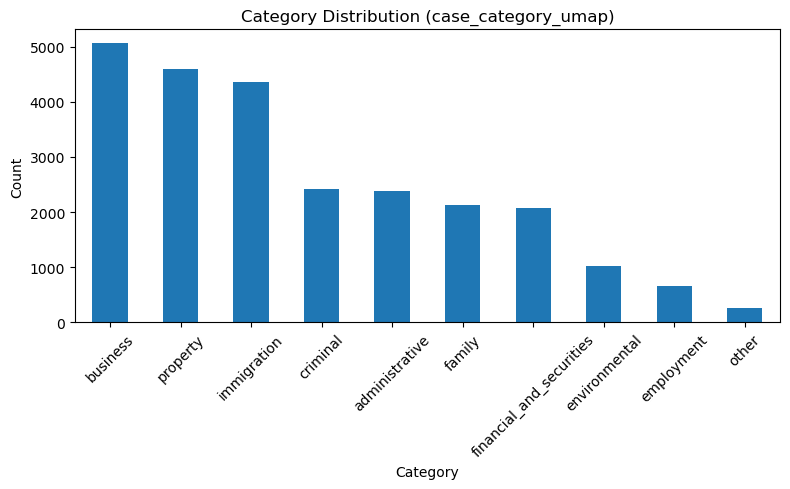

In [ ]:
cluster_to_category = {}
tfidf_cluster = TfidfVectorizer(max_features=50)

for cluster in set(df['cluster_umap_kmeans']):
    cluster_docs = df[df['cluster_umap_kmeans'] == cluster]['cleaned_text']
    cluster_docs = cluster_docs[cluster_docs.str.strip().astype(bool)]  
    if cluster_docs.empty:
        cluster_to_category[cluster] = 'other'
        continue

    cluster_tfidf = tfidf_cluster.fit_transform(cluster_docs)
    feature_names = tfidf_cluster.get_feature_names_out()

    top_terms = [feature_names[i] for i in cluster_tfidf.mean(axis=0).A1.argsort()[-10:]]
    print(f"Top terms for cluster {cluster}: {top_terms}")
    category_counts = {
        cat: sum(term in keywords[cat] for term in top_terms)
        for cat in keywords
    }

    cluster_to_category[cluster] = max(category_counts, key=category_counts.get) if category_counts else 'other'
    print(f"Cluster {cluster} -> {cluster_to_category[cluster]}")

df['case_category_umap'] = df['cluster_umap_kmeans'].map(cluster_to_category)
print("UMAP + KMeans Category Distribution:")
print(df['case_category_umap'].value_counts())

evaluate_category_distribution(df, column='case_category_umap')

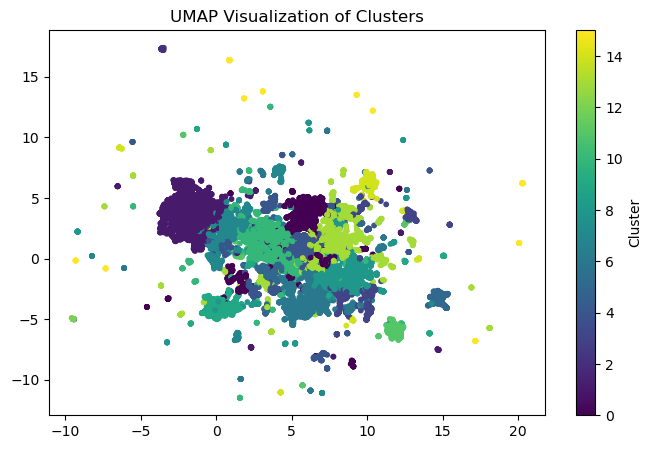

In [82]:
umap_2d = UMAP(n_components=2, random_state=777, metric='cosine', n_jobs=-1)
reduced_data = umap_2d.fit_transform(tfidf_matrix)
plt.figure(figsize=(8, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster_umap_kmeans'], cmap='viridis', s=10)
plt.title('UMAP Visualization of Clusters')
plt.colorbar(label='Cluster')
plt.show()

In [84]:
output_file = os.path.join(output_dir, 'clustered_legal_text.csv')
df.to_csv(output_file, index=False)
print(f"Clustered dataset saved to {output_file}")

for cluster in set(df['cluster_umap_kmeans']):
    print(f"Sample documents from Cluster {cluster}:")
    print(df[df['cluster_umap_kmeans'] == cluster]['cleaned_text'].head(5))

Clustered dataset saved to legalData\clustered_legal_text.csv
Sample documents from Cluster 0:
12    suggested proceeding far commonwealth revenue ...
13    strictly speaking cheque even bank cheque form...
17    assuming deputy commissioner ought presently r...
25    june made order extending convening period mee...
26    june made order extending convening period mee...
Name: cleaned_text, dtype: object
Sample documents from Cluster 1:
18    satisfied finding third tribunal two appellant...
19    plain order set aside matter remitted tribunal...
20    plain order set aside matter remitted tribunal...
21    j minister immigration amp multicultural affai...
23    j said waterford v commonwealth hca clr error ...
Name: cleaned_text, dtype: object
Sample documents from Cluster 2:
24      
107     
972     
1067    
1081    
Name: cleaned_text, dtype: object
Sample documents from Cluster 3:
135    however statutory right damage account profit ...
138    principle stated gummow j wanem pty